In [1]:
from model.model import *
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.stats import rankdata

In [52]:
config = Config(
    n_features = 100,
    n_hidden = 5,
    n_experts = 4,
    n_active_experts = 1,
    load_balancing_loss = False,
)


model = MoEModel(
    config=config,
    device=DEVICE,
    importance = 0.7**torch.arange(config.n_features), # torch.ones(config.n_features),
    feature_probability = torch.tensor(0.1)
)

In [ ]:
optimize(model, n_batch=1024, steps=10000, print_freq=1000)

In [5]:
def render_features(model):
  cfg = model.config
  # expert weights
  W_exp = model.W_experts.detach()
  W_norm = W_exp / (1e-5 + torch.linalg.norm(W_exp, 2, dim=2, keepdim=True))

  interference = torch.einsum('ifh,igh->ifg', W_norm, W_exp) # (n_experts, n_features, n_features)
  interference[:, torch.arange(cfg.n_features), torch.arange(cfg.n_features)] = 0 # set diagonal to 0

  polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()

  if model.feature_probability.dim() == 0:
    feature_prob_expanded = model.feature_probability.expand(cfg.n_features)
  else:
    feature_prob_expanded = model.feature_probability
  net_interference = (interference**2 * feature_prob_expanded[None, None, :]).sum(-1).cpu()
  norms = torch.linalg.norm(W_exp, 2, dim=-1).cpu()

  WWT = torch.einsum('eij,ekj->eik', W_exp, W_exp).cpu() # (n_experts, n_features, n_features)

  # width = weights[0].cpu()
  # x = torch.cumsum(width+0.1, 0) - width[0]
  x = torch.arange(cfg.n_features)
  width = 0.9

  fig = make_subplots(
      rows=cfg.n_experts,  # Row per expert
      cols=2,  # Column 1: bar graphs, Column 2: heatmaps
      shared_xaxes=False,
      vertical_spacing=0.1, # increased from 0.05 to 0.1
      horizontal_spacing=0.1,
      subplot_titles=[f"expert {i}" if j == 0 else "" 
               for i in range(cfg.n_experts) for j in range(2)],
    #   subplot_titles=[f"expert {i}" if j == 0 else f"expert {i}" 
                    #  for i in range(cfg.n_experts) for j in range(2)],
  )
  for expert_idx in range(cfg.n_experts):
        fig.add_trace(
          go.Bar(
              x=x, 
              y=norms[expert_idx],
              marker=dict(
                  color=polysemanticity[expert_idx],
                  cmin=0,
                  cmax=1
              ),
          ),
          row=expert_idx+1, col=1  # Left column for bar graphs
      )
      # Column 2: WWT heatmap for this expert
        fig.add_trace(
          go.Image(
              z=plt.cm.coolwarm((1 + WWT[expert_idx].numpy())/2, bytes=True),
              colormodel='rgba256',
              customdata = WWT[expert_idx].numpy(),
              hovertemplate=f'expert {expert_idx}<br>In: %{{x}}<br>Out: %{{y}}<br> weight: %{{customdata:0.2f}}',
          ),
          row=expert_idx+1, col=2  # Right column for heatmaps
      )

  for expert_idx in range(cfg.n_experts):
      fig.add_vline(
          x=(x[cfg.n_hidden-1]+x[cfg.n_hidden])/2, 
          line=dict(width=0.5),
          row=expert_idx+1,
          col=1,
      )
    
  fig.update_layout(
      showlegend=False, 
      width=800,  # Fixed width for 2 columns
      height=300 * cfg.n_experts,  # Scale height with number of experts
      margin=dict(t=50, b=50)  # increased bottom margin from 20 to 50
  )
  
  # Show x-axes for bar graphs (column 1) and hide for heatmaps (column 2)
  fig.update_xaxes(visible=True, col=1)
  fig.update_xaxes(visible=False, col=2)
  
  fig.update_yaxes(visible=True, col=1)
  fig.update_yaxes(visible=True, title="norm", row=1, col=1)  # Only on first row

  # fig.write_html("wtw.html")
  
  return fig

In [9]:
render_features(model)

In [16]:
def expert_feat_dimensionality(model):
    """fraction of a dimension within an expert that is occupied by a feature."""
    n_experts = model.config.n_experts
    n_features = model.config.n_features
    
    # Initialize tensor to store results for all experts
    all_dimensionalities = torch.zeros(n_experts, n_features)
    
    for expert_idx in range(n_experts):
        W_expert = model.W_experts[expert_idx]  # shape: [n_features, n_hidden]
        W_norm_squared = torch.sum(W_expert**2, dim=1)  # shape: [n_features], ||W_i||^2
        W_hat = W_expert / torch.sqrt(W_norm_squared).unsqueeze(1) # W_hat_i = W_i / ||W_i||
        dot_products = torch.mm(W_hat, W_expert.T) # W_hat_i · W_j
        squared = dot_products**2
        interference = torch.sum(squared, dim=1) # sum of squared dot products for each feature
        dimensionality = W_norm_squared / interference # D_i^(e) = ||W_i^(e)||^2 / sum_j(W_hat_i · W_j)^2
        all_dimensionalities[expert_idx] = dimensionality
    
    return torch.round(all_dimensionalities, decimals=3)

In [17]:
expert_feat_dimensionality(model)

tensor([[0.4960, 1.0000, 0.5040, 0.5140, 0.5020, 0.4970, 0.4850, 0.9950, 0.0000,
         0.0030, 0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.5070, 0.5260, 0.4930, 0.9940, 0.5070, 0.4930, 0.0040, 0.4740, 0.5310,
         0.0010, 0.4680, 0.0000, 0.0000, 0.0020, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.5210, 0.5300, 0.5150, 0.5050, 0.5170, 0.4950, 0.4790, 0.4700, 0.4830,
         0.4830, 0.0020, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [1.0000, 0.5070, 0.9970, 0.4930, 0.4620, 0.0020, 0.5160, 0.1900, 0.4060,
         0.4220, 0.0010, 0.0010, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000]], grad_fn=<RoundBackward1>)

global feature Dimensionality for feature $i$ is given by:

$$
D_i^{\text{global}} \;=\; \sum_{e} \alpha_i^{(e)} \cdot D_i^{(e)}
$$

where:

- $D_i^{(e)}$ = dimensionality of feature $i$ in expert $e$  
- $\alpha_i^{(e)}$ = activation rate of expert $e$ **given** that feature $i$ is present:
$$
\alpha_i^{(e)} \;=\; \frac{\text{\# times expert $e$ active when feature $i$ present}}{\text{\# times feature $i$ present}}
$$

measures how much each expert contributes to representing feature $i$, weighted by the feature-specific routing frequency.


In [18]:
def global_feat_dim(model, input_features=None, n_batch=1024):
    """
    compute global feature dimensionality for MoE model.
    
    D_i^global = Σ_e alpha_i^(e) · D_i^(e)
    
    where:
    - D_i^(e) is dimensionality of feature i in expert e
    - alpha_i^(e) is feature-specific activation rate of expert e for feature i
    """
    if input_features is None:
        input_features = model.generate_batch(n_batch)
    
    # expert dimensionalities D_i^(e) for all features and experts
    expert_dims = expert_feat_dimensionality(model) # [n_experts, n_features]
    
    # expert activation patterns
    expert_weights, top_k_indices, _ = model.compute_active_experts(input_features)
    # expert_weights: [n_batch, n_experts]
    # top_k_indices: [n_batch, n_active_experts]
    
    # binary activation mask for all experts
    # active_mask[b, e] = 1 if expert e is active for batch b, 0 otherwise
    active_mask = torch.zeros_like(expert_weights)  # [n_batch, n_experts]
    active_mask = active_mask.scatter(-1, top_k_indices, 1.0)
    
    # feature-specific activation rates α_i^(e)
    # for each feature i, we need the activation rate of expert e 
    # only when feature i is present (non-zero)
    
    # which batch examples have each feature present
    feature_present = (input_features > 0).float()  # [n_batch, n_features]
    
    # Count how many times each feature appears
    feature_counts = torch.sum(feature_present, dim=0)  # [n_features]
    
    # for each feature i and expert e, count how often expert e is active when feature i is present
    # feature_present: [n_batch, n_features]
    # active_mask: [n_batch, n_experts]
    
    # [n_batch, n_features, 1] * [n_batch, 1, n_experts]
    feature_expert_cooccurrence = torch.einsum('bf,be->fe', feature_present, active_mask)
    
    # activation rates α_i^(e) = cooccurrence / feature_counts
    # handle division by zero for features that never appear
    alpha = torch.where(
        feature_counts.unsqueeze(-1) > 0,
        feature_expert_cooccurrence / feature_counts.unsqueeze(-1),
        torch.zeros_like(feature_expert_cooccurrence)
    )  # [n_features, n_experts]
    
    # global dimensionality D_i^global = Σ_e α_i^(e) · D_i^(e)
    # alpha: [n_features, n_experts]
    # expert_dims: [n_experts, n_features] -> transpose to [n_features, n_experts]
    global_dims = torch.sum(alpha * expert_dims.T, dim=-1)  # [n_features]
    
    return torch.round(global_dims, decimals=3)

In [ ]:
global_feat_dim(model, n_batch=1024)

In [149]:
density_vals = [round(1.0 - i * (0.9 / 19), 2) for i in range(20)]
density_vals

[1.0,
 0.95,
 0.91,
 0.86,
 0.81,
 0.76,
 0.72,
 0.67,
 0.62,
 0.57,
 0.53,
 0.48,
 0.43,
 0.38,
 0.34,
 0.29,
 0.24,
 0.19,
 0.15,
 0.1]

In [40]:
def feat_per_dim_exp(model):
    """
    compute per-expert dimensionality using Frobenius norm.
    """
    # W_experts: [n_experts, n_features, n_hidden]
    W = model.W_experts
    m = model.config.n_hidden
    
    # compute Frobenius norm for each expert: ||W^{(e)}||_F^2
    # frobenius norm squared for each expert weight matrix
    fro_norm_squared = torch.norm(W, p='fro', dim=(1, 2))**2  # [n_experts]
    feat_per_dim_per_expert = fro_norm_squared / m  # [n_experts]
    return feat_per_dim_per_expert

In [41]:
def weighted_avg_features_per_dim(model, n_samples=1024):
    """
    compute weighted average features per dimension using expert usage probabilities.
    
    features per dimension_global = sum(p_e * ||W^e||_F^2 / n) for e=1 to E
    
    where p_e is the probability/frequency that expert e is used (derived from gating mechanism).
    """
    # generate batch to compute expert usage probabilities
    batch = model.generate_batch(n_samples)

    k = model.config.n_active_experts
    
    # compute active experts and their weights
    expert_weights, top_k_indices, _ = model.compute_active_experts(batch)
    
    # compute p_e: probability/frequency that expert e is used
    # sum over all samples and normalize
    expert_usage = torch.sum(expert_weights, dim=0) / n_samples  # [n_experts]
    
    # compute ||W^e||_F^2 / n for each expert using the existing function
    feat_per_dim_per_expert = feat_per_dim_exp(model)  # [n_experts]
    
    # weighted average: sum(p_e * ||W^e||_F^2 / n)
    weighted_features_per_dim = torch.sum(expert_usage * feat_per_dim_per_expert) / k
    
    return weighted_features_per_dim, expert_usage, feat_per_dim_per_expert

In [ ]:
config = Config(
    n_features = 100,
    n_hidden = 5,
    n_experts = 4,
    n_active_experts = 1,
    load_balancing_loss = False,
)


model = MoEModel(
    config=config,
    device=DEVICE,
    importance = 0.7**torch.arange(config.n_features), # torch.ones(config.n_features),
    feature_probability = torch.tensor(0.1)
)

tensor([0.0922, 0.0993, 0.0990, 0.0860, 0.0997], grad_fn=<DivBackward0>)

In [54]:
feat_per_dim_global, expert_usage, feat_per_dim_per_expert = weighted_avg_features_per_dim(model)
print(feat_per_dim_global)
print(expert_usage)
print(feat_per_dim_per_expert)

tensor(0.0843, grad_fn=<SumBackward0>)
tensor([0.1846, 0.2246, 0.1660, 0.4248], grad_fn=<DivBackward0>)
tensor([0.0902, 0.0709, 0.0793, 0.0907], grad_fn=<DivBackward0>)


In [55]:
# global_dims = global_feat_dim(model)
# print(global_dims)
# total_dims = torch.sum(global_dims)
# total_dims

In [ ]:
exp_dims = expert_feat_dimensionality(model)
# print(exp_dims)

# sum across features for each expert (sum along dimension 1)
expert_total_dims = torch.sum(exp_dims, dim=1)
print("total dimensions per expert:")
print(expert_total_dims)
# sum across all experts to get total dimensions
total_dims_across_experts = torch.sum(expert_total_dims)
print("total dimensions across all experts:")
print(total_dims_across_experts)

In [ ]:
feat_per_dim_global, expert_usage, feat_per_dim_per_expert = weighted_avg_features_per_dim(model)
print(feat_per_dim_global)
print(expert_usage)
print(feat_per_dim_per_expert)

In [ ]:
exp_dims = expert_feat_dimensionality(model)
# sum across features for each expert
expert_total_dims = torch.sum(exp_dims, dim=1)
print("total dimensions per expert:")
print(expert_total_dims)

In [26]:
def extract_individual_models(stacked_params, configs, feature_probs, importances, device):
    """extract individual model instances from stacked parameters"""
    num_models = stacked_params['W_experts'].shape[0]
    individual_models = []
    
    for i in range(num_models):
        # Create a proper MoEModel instance
        model = MoEModel(configs[i], feature_probs[i], importances[i], device=device)
        
        # Load the stacked parameters into this model
        model.W_experts.data = stacked_params['W_experts'][i]
        model.b_final.data = stacked_params['b_final'][i]  
        model.gate.data = stacked_params['gate'][i]
        
        individual_models.append(model)
    
    return individual_models

In [3]:
def plot_feats_per_dim(stacked_params, configs, feature_probs, importances, device):
    """calculate weighted average features per dimension and create plot"""
    
    individual_models = extract_individual_models(stacked_params, configs, feature_probs, importances, device)
    # calculate weighted average features per dimension
    weighted_feats_per_dim = []
    for model in individual_models:
        weighted_feat_per_dim, _, _ = weighted_avg_features_per_dim(model)
        weighted_feats_per_dim.append(weighted_feat_per_dim.item())
    
    # transform to x-axis values (feature_probs = 1-s, so 1/(1-s) = 1/feature_probs)
    x_values = []
    for s in feature_probs:
        s_val = s.item()
        if s_val <= 0:
            # if s <= 0, use a very large value instead of infinity
            x_values.append(1000)  
        else:
            x_values.append(1 / s_val)
    
    # create plot
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=x_values,
        y=weighted_feats_per_dim,
        mode='markers+lines',
        name='Weighted Features per Dimension',
        line=dict(width=3, color='black'),
        marker=dict(size=8, color='black')
    ))
    
    # update layout
    fig.update_layout(
        title="Number of features per dimension",
        xaxis=dict(
            title="1/(1-S) (log scale)",
            type="log",
        ),
        yaxis=dict(
            title="Number of features per dimension",
            range=[0, max(weighted_feats_per_dim) * 1.1],
        ),
        showlegend=False,
        width=800,
        height=600
    )
    
    # add reference lines
    fig.add_hline(y=1, line_dash="dot", line_color="orange", opacity=0.7)
    # fig.add_hline(y=0.5, line_dash="dot", line_color="orange", opacity=0.7)
    
    return fig


In [ ]:
density_vals = [round(1.0 - i * (0.9 / 19), 2) for i in range(20)]

configs_dense = [
    Config(n_features=100, n_hidden=20, n_experts=1, n_active_experts=1, load_balancing_loss=False)
    for _ in density_vals
    ]

feature_probs = [torch.tensor(density) for density in density_vals]
importances = [torch.ones(config.n_features) for config in configs_dense]

loss_dense, stacked_params_dense = optimize_vectorized(configs_dense, feature_probs, importances, n_batch=1024, steps=10000, device=DEVICE, print_freq=1000)

In [96]:
plot_feats_per_dim(stacked_params_dense, configs_dense, feature_probs, importances, DEVICE)

In [ ]:
def plot_feats_per_dim_comparison(stacked_params_dense, configs_dense, stacked_params_moe, configs_moe, feature_probs, importances, device):
    """compare weighted average features per dimension between dense and MoE models"""
    
    # extract individual models for dense
    individual_models_dense = extract_individual_models(stacked_params_dense, configs_dense, feature_probs, importances, device)
    
    # extract individual models for moe
    individual_models_moe = extract_individual_models(stacked_params_moe, configs_moe, feature_probs, importances, device)
    
    # calculate weighted average features per dimension for dense
    weighted_feats_per_dim_dense = []
    for model in individual_models_dense:
        weighted_feat_per_dim, _, _ = weighted_avg_features_per_dim(model)
        weighted_feats_per_dim_dense.append(weighted_feat_per_dim.item())
    
    # calculate weighted average features per dimension for moe
    weighted_feats_per_dim_moe = []
    for model in individual_models_moe:
        weighted_feat_per_dim, _, _ = weighted_avg_features_per_dim(model)
        weighted_feats_per_dim_moe.append(weighted_feat_per_dim.item())
    
    # transform to x-axis values (feature_probs = 1-s, so 1/(1-s) = 1/feature_probs)
    x_values = []
    for s in feature_probs:
        s_val = s.item()
        if s_val <= 0:
            # if s <= 0, use a very large value instead of infinity
            x_values.append(1000)  
        else:
            x_values.append(1 / s_val)
    
    # create plot
    fig = go.Figure()
    
    # add dense model trace
    fig.add_trace(go.Scatter(
        x=x_values,
        y=weighted_feats_per_dim_dense,
        mode='markers+lines',
        name='Dense Model',
        line=dict(width=3, color='blue'),
        marker=dict(size=8, color='blue')
    ))
    
    # add moe model trace
    fig.add_trace(go.Scatter(
        x=x_values,
        y=weighted_feats_per_dim_moe,
        mode='markers+lines',
        name='MoE Model',
        line=dict(width=3, color='red'),
        marker=dict(size=8, color='red')
    ))
    
    # update layout
    fig.update_layout(
        title="Number of features per dimension: Dense vs MoE",
        xaxis=dict(
            title="1/(1-S) (log scale)",
            type="log",
        ),
        yaxis=dict(
            title="Number of features per dimension",
            range=[0, max(max(weighted_feats_per_dim_dense), max(weighted_feats_per_dim_moe)) * 1.1],
        ),
        showlegend=True,
        width=800,
        height=600
    )
    
    # add reference lines
    fig.add_hline(y=1, line_dash="dot", line_color="orange", opacity=0.7)
    
    return fig

In [27]:
def plot_feats_per_dim_comp(stacked_params_list, configs_list, labels, feature_probs, importances, device):
    """compare weighted average features per dimension between multiple models
    
    Args:
        stacked_params_list: list of stacked parameters for different model types
        configs_list: list of configs corresponding to each stacked_params
        labels: list of labels for each model type (e.g., ['Dense', 'MoE w/ 3 experts'])
        feature_probs: list of feature probabilities (shared across all model types)
        importances: list of importance values (shared across all model types)
    """
    
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']
    
    # calculate weighted average features per dimension for each model type
    all_weighted_feats_per_dim = []
    for stacked_params, configs in zip(stacked_params_list, configs_list):
        # extract individual models
        individual_models = extract_individual_models(stacked_params, configs, feature_probs, importances, device)
        
        # calculate weighted average features per dimension
        weighted_feats_per_dim = []
        for model in individual_models:
            weighted_feat_per_dim, _, _ = weighted_avg_features_per_dim(model)
            weighted_feats_per_dim.append(weighted_feat_per_dim.item())
        
        all_weighted_feats_per_dim.append(weighted_feats_per_dim)
    
    # transform to x-axis values (feature_probs = 1-s, so 1/(1-s) = 1/feature_probs)
    x_values = []
    for s in feature_probs:
        s_val = s.item() if torch.is_tensor(s) else s
        if s_val <= 0:
            # if s <= 0, use a very large value instead of infinity
            x_values.append(1000)  
        else:
            x_values.append(1 / s_val)
    
    # create plot
    fig = go.Figure()
    
    # add trace for each model type
    for i, (weighted_feats_per_dim, label) in enumerate(zip(all_weighted_feats_per_dim, labels)):
        color = colors[i % len(colors)]
        fig.add_trace(go.Scatter(
            x=x_values,
            y=weighted_feats_per_dim,
            mode='markers+lines',
            name=label,
            line=dict(width=3, color=color),
            marker=dict(size=8, color=color)
        ))
    
    # calculate max y value for range
    max_y = max(max(feats) for feats in all_weighted_feats_per_dim)
    
    # update layout
    fig.update_layout(
        title=f"Number of features per dimension across {len(labels)} models",
        xaxis=dict(
            title="1/(1-S) (log scale)",
            type="log",
        ),
        yaxis=dict(
            title="Number of features per dimension",
            range=[0, max_y * 1.1],
        ),
        showlegend=True,
        width=800,
        height=600
    )
    
    # add reference lines
    fig.add_hline(y=1, line_dash="dot", line_color="orange", opacity=0.7)
    
    return fig

In [28]:
a = torch.load('weights-loss/stacked_params_dense.pt')
b = torch.load('weights-loss/stacked_params_moe-4t-1a.pt')
c = torch.load('weights-loss/stacked_params_moe-10t-2a.pt')
d = torch.load('weights-loss/stacked_params_moe-20t-5a.pt')

In [46]:
density_vals = [round(1.0 - i * (0.9 / 29), 2) for i in range(30)]

cfg_a = [
    Config(n_features=100, n_hidden=20, n_experts=1, n_active_experts=1, load_balancing_loss=False)
    for _ in density_vals
    ]

cfg_b = [
    Config(n_features=100, n_hidden=20, n_experts=4, n_active_experts=1, load_balancing_loss=False)
    for _ in density_vals
    ]

cfg_c = [
    Config(n_features=100, n_hidden=20, n_experts=10, n_active_experts=2, load_balancing_loss=False)
    for _ in density_vals
    ]

cfg_d = [
    Config(n_features=100, n_hidden=20, n_experts=20, n_active_experts=5, load_balancing_loss=False)
    for _ in density_vals
    ]

feature_probs = [torch.tensor(density) for density in density_vals]
importances = [torch.ones(config.n_features) for config in cfg_a]

In [47]:
plot_feats_per_dim_comp([a, b, c, d], [cfg_a, cfg_b, cfg_c, cfg_d], 
['Dense', 'MoE w/ 4 experts', 'MoE w/ 10 experts', 'MoE w/ 20 experts'], 
feature_probs, importances, DEVICE)

In [105]:
density_vals_30 = [round(1.0 - i * (0.9 / 29), 2) for i in range(30)]

configs_dense_30 = [
    Config(n_features=100, n_hidden=20, n_experts=1, n_active_experts=1, load_balancing_loss=False)
    for _ in density_vals_30
    ]

feature_probs_30 = [torch.tensor(density) for density in density_vals_30]
importances_30 = [torch.ones(config.n_features) for config in configs_dense_30]

loss_dense_30, stacked_params_dense_30 = optimize_vectorized(configs_dense_30, feature_probs_30, importances_30, n_batch=1024, steps=10000, device=DEVICE, print_freq=1000)

Step 0: avg_loss=0.159095, lr=0.001000
Step 1000: avg_loss=0.069632, lr=0.001000
Step 2000: avg_loss=0.068747, lr=0.001000
Step 3000: avg_loss=0.068349, lr=0.001000
Step 4000: avg_loss=0.068244, lr=0.001000
Step 5000: avg_loss=0.068358, lr=0.001000
Step 6000: avg_loss=0.068195, lr=0.001000
Step 7000: avg_loss=0.068122, lr=0.001000
Step 8000: avg_loss=0.068287, lr=0.001000
Step 9000: avg_loss=0.068154, lr=0.001000
Step 9999: avg_loss=0.068227, lr=0.001000


In [104]:
density_vals_30 = [round(1.0 - i * (0.9 / 29), 2) for i in range(30)]

configs_moe_30 = [
    Config(n_features=100, n_hidden=5, n_experts=4, n_active_experts=1, load_balancing_loss=False)
    for _ in density_vals_30
    ]

feature_probs_30 = [torch.tensor(density) for density in density_vals_30]
importances_30 = [torch.ones(config.n_features) for config in configs_moe_30]

loss_moe_30, stacked_params_moe_30 = optimize_vectorized(configs_moe_30, feature_probs_30, importances_30, n_batch=1024, steps=10000, device=DEVICE, print_freq=1000)

Step 0: avg_loss=0.158245, lr=0.001000
Step 1000: avg_loss=0.089433, lr=0.001000
Step 2000: avg_loss=0.088933, lr=0.001000
Step 3000: avg_loss=0.088790, lr=0.001000
Step 4000: avg_loss=0.088535, lr=0.001000
Step 5000: avg_loss=0.088644, lr=0.001000
Step 6000: avg_loss=0.088659, lr=0.001000
Step 7000: avg_loss=0.088546, lr=0.001000
Step 8000: avg_loss=0.088486, lr=0.001000
Step 9000: avg_loss=0.088656, lr=0.001000
Step 9999: avg_loss=0.088710, lr=0.001000


In [106]:
plot_feats_per_dim_comparison(stacked_params_dense_30, configs_dense_30, stacked_params_moe_30, configs_moe_30, feature_probs_30, importances_30, DEVICE)

#### tex figs

In [150]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feats_per_dim_comparison(stacked_params_dense, configs_dense, stacked_params_moe, configs_moe, feature_probs, importances, device):
    """compare weighted average features per dimension between dense and MoE models"""
    
    # extract individual models for dense
    individual_models_dense = extract_individual_models(stacked_params_dense, configs_dense, feature_probs, importances, device)
    
    # extract individual models for moe
    individual_models_moe = extract_individual_models(stacked_params_moe, configs_moe, feature_probs, importances, device)
    
    # calculate weighted average features per dimension for dense
    weighted_feats_per_dim_dense = []
    for model in individual_models_dense:
        weighted_feat_per_dim, _, _ = weighted_avg_features_per_dim(model)
        weighted_feats_per_dim_dense.append(weighted_feat_per_dim.item())
    
    # calculate weighted average features per dimension for moe
    weighted_feats_per_dim_moe = []
    for model in individual_models_moe:
        weighted_feat_per_dim, _, _ = weighted_avg_features_per_dim(model)
        weighted_feats_per_dim_moe.append(weighted_feat_per_dim.item())
    
    # transform to x-axis values (feature_probs = 1-s, so 1/(1-s) = 1/feature_probs)
    x_values = []
    for s in feature_probs:
        s_val = s.item()
        if s_val <= 0:
            # if s <= 0, use a very large value instead of infinity
            x_values.append(1000)  
        else:
            x_values.append(1 / s_val)
    
    # set up matplotlib for LaTeX
    plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
        'font.serif': ['Computer Modern'],
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'legend.fontsize': 12,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
    })
    
    # create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # plot dense model with classic blue color
    ax.semilogx(x_values, weighted_feats_per_dim_dense, 
                '-', linewidth=3, color='#1f77b4', 
                label='Dense')
    
    # plot moe model with classic orange color
    ax.semilogx(x_values, weighted_feats_per_dim_moe, 
                '-', linewidth=3, color='#ff7f0e', 
                label='MoE (4 experts)')
    
    # add reference line
    ax.axhline(y=1, linestyle='--', color='orange', alpha=0.7, linewidth=2)
    
    # set labels and title with LaTeX formatting
    ax.set_xlabel(r'$\frac{1}{1-S}$ (log scale) $\leftarrow$ dense $|$ sparse $\rightarrow$')
    ax.set_ylabel(r'Features Per Dimension')
    # ax.set_title(r'Number of features per dimension: Dense vs MoE')
    
    # set y-axis limits
    y_max = max(max(weighted_feats_per_dim_dense), max(weighted_feats_per_dim_moe)) * 1.1
    ax.set_ylim(0, y_max)
    
    # set custom x-axis ticks from 1 to 10
    ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    
    # add legend
    ax.legend()
    
    # add grid for better readability
    ax.grid(True, alpha=0.3)
    
    # tight layout to prevent label cutoff
    plt.tight_layout()
    
    # save as PDF (vector format perfect for LaTeX)
    plt.savefig(f'feats_per_dim_comparison-moe.pdf', format='pdf', bbox_inches='tight', dpi=300)
    
    # also save as PGF for direct LaTeX inclusion
    plt.savefig('feats_per_dim_comparison-moe.pgf', format='pgf', bbox_inches='tight')
    
    # show only once
    plt.show()
    plt.close()  # close the figure to prevent duplicate display
    
    return fig

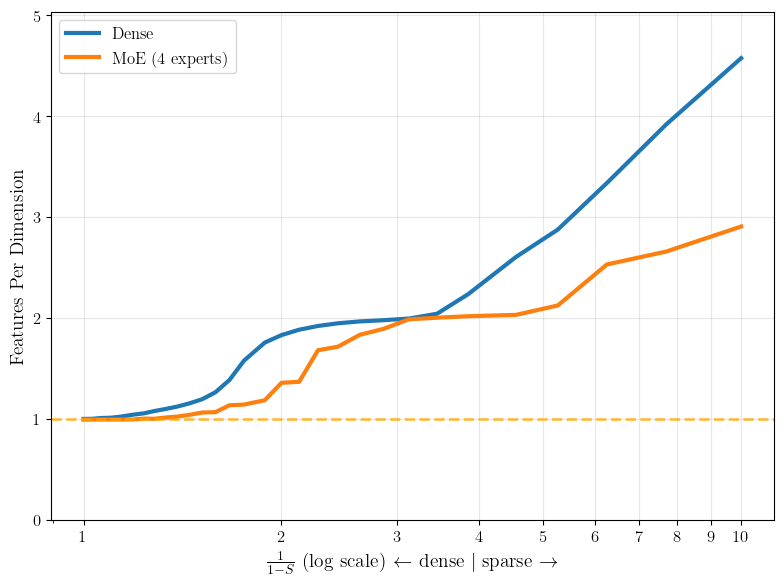

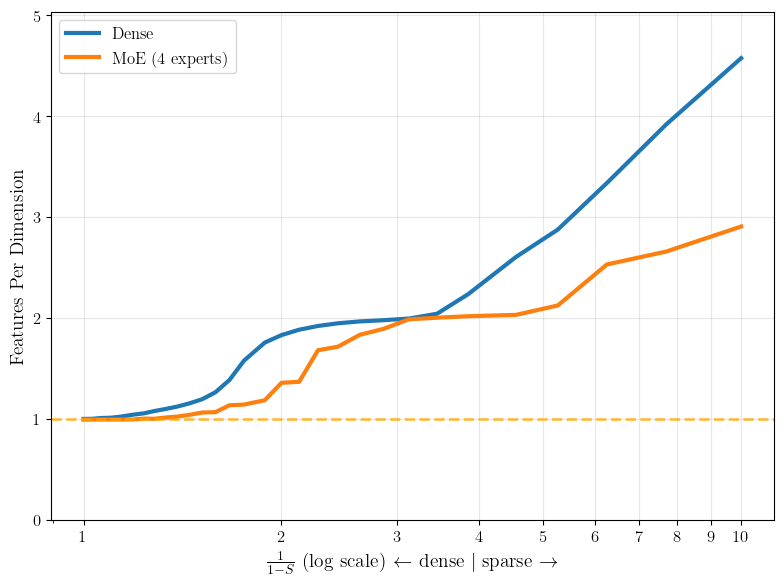

In [133]:
plot_feats_per_dim_comparison(stacked_params_dense_30, configs_dense_30, stacked_params_moe_30, configs_moe_30, feature_probs_30, importances_30, DEVICE)

In [149]:
density_vals_30 = [round(1.0 - i * (0.9 / 29), 2) for i in range(30)]

configs_moe_10 = [
    Config(n_features=100, n_hidden=2, n_experts=10, n_active_experts=2, load_balancing_loss=False)
    for _ in density_vals_30
    ]

feature_probs_10 = [torch.tensor(density) for density in density_vals_30]
importances_10 = [torch.ones(config.n_features) for config in configs_moe_10]

loss_moe_10, stacked_params_moe_10 = optimize_vectorized(configs_moe_10, feature_probs_10, importances_10, n_batch=1024, steps=10000, device=DEVICE, print_freq=1000)

Step 0: avg_loss=0.155244, lr=0.001000
Step 1000: avg_loss=0.085073, lr=0.001000
Step 2000: avg_loss=0.083990, lr=0.001000
Step 3000: avg_loss=0.083622, lr=0.001000
Step 4000: avg_loss=0.083493, lr=0.001000
Step 5000: avg_loss=0.083298, lr=0.001000
Step 6000: avg_loss=0.083100, lr=0.001000
Step 7000: avg_loss=0.082935, lr=0.001000
Step 8000: avg_loss=0.082834, lr=0.001000
Step 9000: avg_loss=0.082910, lr=0.001000
Step 9999: avg_loss=0.082698, lr=0.001000


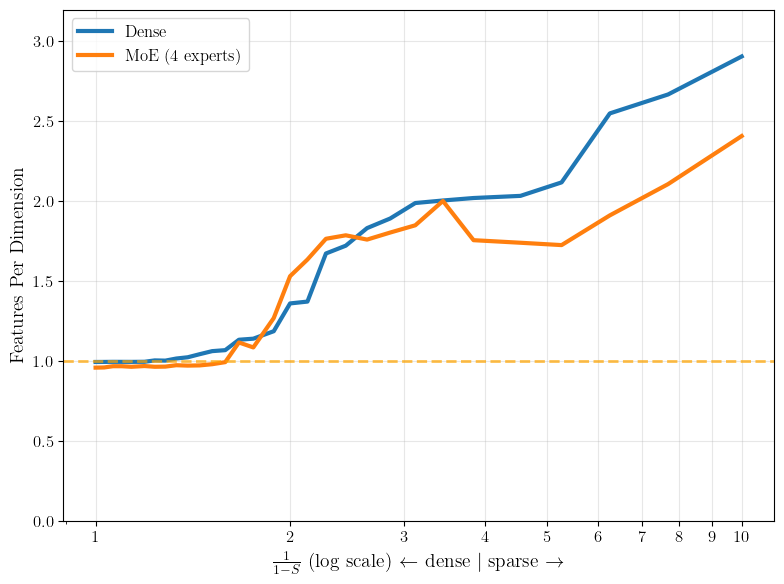

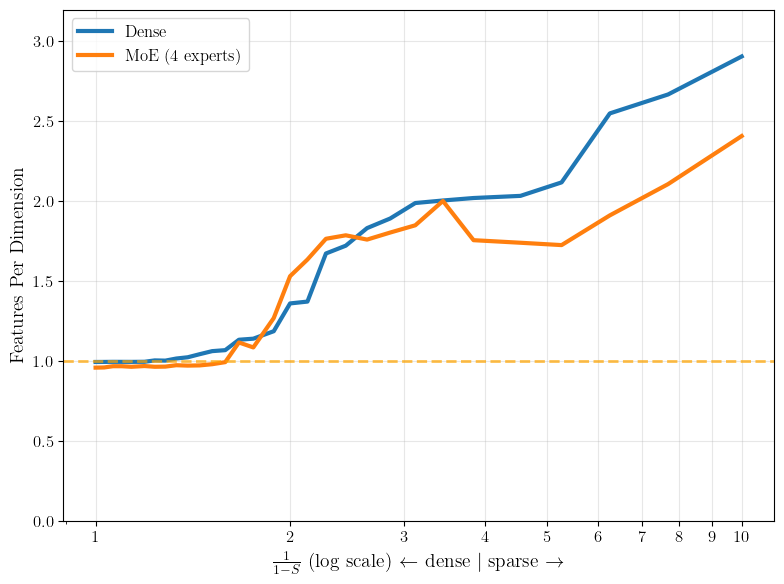

In [154]:
plot_feats_per_dim_comparison(stacked_params_moe_30, configs_moe_30, stacked_params_moe_10, configs_moe_10, feature_probs_10, importances_10, DEVICE)

total experts = 20, active = 5, $m=1$ per expert, $n=100$

In [6]:
x = torch.load('dense/loss_dense-1.pt', map_location='cpu')
x.shape

torch.Size([30])

Loaded dense: averaged 5 files
Loaded moe-4t-1a: averaged 5 files
Loaded moe-10t-2a: averaged 5 files
Loaded moe-20t-5a: averaged 5 files


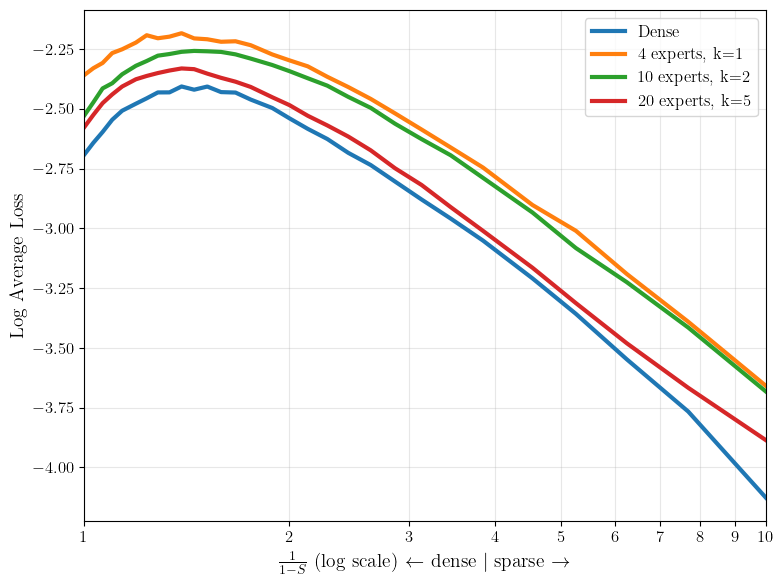

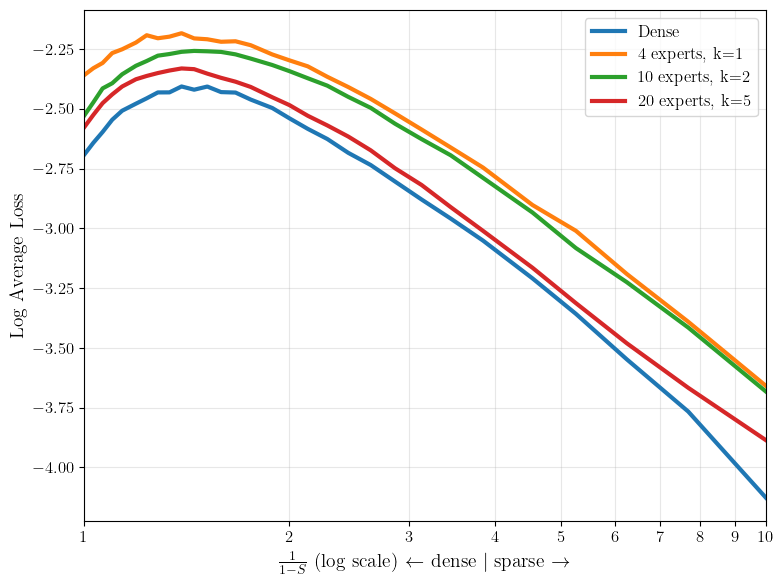

In [98]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob

def plot_loss_comparison_from_folders():
    """Plot average loss values from pt files in different model folders"""
    
    # define the density values (same as in your notebook)
    density_vals_30 = [round(1.0 - i * (0.9 / 29), 2) for i in range(30)]
    
    # transform to x-axis values: 1/(1-s) where s = density_vals_30
    x_values = []
    for s in density_vals_30:
        if s <= 0:
            x_values.append(1000)  # cap for very sparse case
        else:
            x_values.append(1 / s)
    
    # define folder paths and their corresponding labels
    folders = {
        'dense': './weights-loss/dense/',
        'moe-4t-1a': './weights-loss/moe-4t-1a/', 
        'moe-10t-2a': './weights-loss/moe-10t-2a/',
        'moe-20t-5a': './weights-loss/moe-20t-5a/'
    }
    
    labels = {
        'dense': 'Dense',
        'moe-4t-1a': '4 experts, k=1', 
        'moe-10t-2a': '10 experts, k=2',
        'moe-20t-5a': '20 experts, k=5'
    }
    
    def load_and_average_folder(folder_path):
        """Load all .pt files from folder and return averaged tensor"""
        pt_files = glob(os.path.join(folder_path, '*.pt'))
        
        if not pt_files:
            return None
            
        all_tensors = []
        
        for pt_file in pt_files:
            try:
                # load the tensor directly (since each file contains a single tensor)
                tensor = torch.load(pt_file, map_location='cpu')
                
                # ensure it's a tensor and has 30 elements
                if isinstance(tensor, torch.Tensor) and tensor.numel() == 30:
                    all_tensors.append(tensor.flatten())  # flatten in case it's not 1D
                else:
                    print(f"Warning: {pt_file} doesn't contain a 30-element tensor")
                    
            except Exception as e:
                print(f"Error loading {pt_file}: {e}")
                continue
        
        if not all_tensors:
            return None
            
        # stack and average across all files (files 1-5 for each folder)
        stacked_tensors = torch.stack(all_tensors)
        averaged_tensor = stacked_tensors.mean(dim=0)
        
        return averaged_tensor
    
    # load and average data from all folders
    folder_data = {}
    
    for folder_name, folder_path in folders.items():
        avg_tensor = load_and_average_folder(folder_path)
        if avg_tensor is not None:
            folder_data[folder_name] = {
                'values': avg_tensor,
                'label': labels[folder_name]
            }
            print(f"Loaded {folder_name}: averaged {len(glob(os.path.join(folder_path, '*.pt')))} files")
        else:
            print(f"No valid data found in {folder_name}")
    
    # set up matplotlib for LaTeX (same as your original function)
    plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
        'font.serif': ['Computer Modern'],
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'legend.fontsize': 12,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
    })
    
    # create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # define colors for each model type
    colors = {
        'dense': '#1f77b4',      # blue
        'moe-4t-1a': '#ff7f0e',  # orange  
        'moe-10t-2a': '#2ca02c', # green
        'moe-20t-5a': '#d62728'  # red
    }
    
    # plot data for each folder
    for folder_name, data in folder_data.items():
        values = data['values'].detach().numpy()  # convert to numpy for plotting
        
        # take log of the loss values
        log_values = np.log(values)
        
        # plot with semilog x-axis
        ax.semilogx(x_values, log_values,
                   '-', linewidth=3, color=colors[folder_name], 
                   label=data['label'])
    
    # set labels and formatting
    ax.set_xlabel(r'$\frac{1}{1-S}$ (log scale) $\leftarrow$ dense $|$ sparse $\rightarrow$')
    ax.set_ylabel(r'Log Average Loss')
    
    # set x-axis limits and ticks (from 1 to 10 as in your original function)
    ax.set_xlim(1, 10)
    ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    
    # add legend and grid
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # tight layout
    plt.tight_layout()
    
    # save the plot
    plt.savefig('loss_comparison_all_models.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.savefig('loss_comparison_all_models.pgf', format='pgf', bbox_inches='tight')
    
    # show and close
    plt.show()
    plt.close()
    
    return fig

# call the function
plot_loss_comparison_from_folders()


In [27]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feats_per_dim_comparison_all(stacked_params_dense_30, configs_dense_30, stacked_params_moe_30, configs_moe_30, stacked_params_moe_10, configs_moe_10, stacked_params_moe_20, configs_moe_20, feature_probs_30, importances_30, feature_probs_10, importances_10, feature_probs_20, importances_20):
    """compare weighted average features per dimension between Dense and MoE models with different expert counts"""
    
    # extract individual models for dense
    individual_models_dense_30 = extract_individual_models(stacked_params_dense_30, configs_dense_30, feature_probs_30, importances_30, device=DEVICE)
    
    # extract individual models for moe 30 experts
    individual_models_moe_30 = extract_individual_models(stacked_params_moe_30, configs_moe_30, feature_probs_30, importances_30, device=DEVICE)
    
    # extract individual models for moe 10 experts
    individual_models_moe_10 = extract_individual_models(stacked_params_moe_10, configs_moe_10, feature_probs_10, importances_10, device=DEVICE)
    
    # extract individual models for moe 20 experts
    individual_models_moe_20 = extract_individual_models(stacked_params_moe_20, configs_moe_20, feature_probs_20, importances_20, device=DEVICE)
    
    # calculate weighted average features per dimension for dense
    weighted_feats_per_dim_dense_30 = []
    for model in individual_models_dense_30:
        weighted_feat_per_dim, _, _ = weighted_avg_features_per_dim(model)
        weighted_feats_per_dim_dense_30.append(weighted_feat_per_dim.item())
    
    # calculate weighted average features per dimension for moe 30 experts
    weighted_feats_per_dim_moe_30 = []
    for model in individual_models_moe_30:
        weighted_feat_per_dim, _, _ = weighted_avg_features_per_dim(model)
        weighted_feats_per_dim_moe_30.append(weighted_feat_per_dim.item())
    
    # calculate weighted average features per dimension for moe 10 experts
    weighted_feats_per_dim_moe_10 = []
    for model in individual_models_moe_10:
        weighted_feat_per_dim, _, _ = weighted_avg_features_per_dim(model)
        weighted_feats_per_dim_moe_10.append(weighted_feat_per_dim.item())
    
    # calculate weighted average features per dimension for moe 20 experts
    weighted_feats_per_dim_moe_20 = []
    for model in individual_models_moe_20:
        weighted_feat_per_dim, _, _ = weighted_avg_features_per_dim(model)
        weighted_feats_per_dim_moe_20.append(weighted_feat_per_dim.item())
    
    # transform to x-axis values (feature_probs = 1-s, so 1/(1-s) = 1/feature_probs)
    x_values_30 = []
    for s in feature_probs_30:
        s_val = s.item()
        if s_val <= 0:
            # if s <= 0, use a very large value instead of infinity
            x_values_30.append(1000)  
        else:
            x_values_30.append(1 / s_val)
    
    x_values_10 = []
    for s in feature_probs_10:
        s_val = s.item()
        if s_val <= 0:
            # if s <= 0, use a very large value instead of infinity
            x_values_10.append(1000)  
        else:
            x_values_10.append(1 / s_val)
    
    x_values_20 = []
    for s in feature_probs_20:
        s_val = s.item()
        if s_val <= 0:
            # if s <= 0, use a very large value instead of infinity
            x_values_20.append(1000)  
        else:
            x_values_20.append(1 / s_val)
    
    # set up matplotlib for LaTeX
    plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
        'font.serif': ['Computer Modern'],
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'legend.fontsize': 12,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
    })
    
    # create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # plot dense model with blue color
    ax.semilogx(x_values_30, weighted_feats_per_dim_dense_30, 
                '-', linewidth=3, color='#1f77b4', 
                label='Dense')
    
    # plot moe model with 4 experts with classic orange color
    ax.semilogx(x_values_30, weighted_feats_per_dim_moe_30, 
                '-', linewidth=3, color='#ff7f0e', 
                label='4 experts, $k=1$')
    
    # plot moe model with 10 experts with green color
    ax.semilogx(x_values_10, weighted_feats_per_dim_moe_10, 
                '-', linewidth=3, color='#2ca02c', 
                label='10 experts, $k=2$')
    
    # plot moe model with 20 experts with red color
    ax.semilogx(x_values_20, weighted_feats_per_dim_moe_20, 
                '-', linewidth=3, color='#d62728', 
                label='20 experts, $k=5$')
    
    # add reference line
    ax.axhline(y=1, linestyle='--', color='orange', alpha=0.7, linewidth=2)
    
    # set labels and title with LaTeX formatting
    ax.set_xlabel(r'$\frac{1}{1-S}$ (log scale) $\leftarrow$ dense $|$ sparse $\rightarrow$')
    ax.set_ylabel(r'Features Per Dimension')
    # ax.set_title(r'Number of features per dimension: Dense vs MoE')
    
    # set y-axis limits
    y_max = max(max(weighted_feats_per_dim_dense_30), max(weighted_feats_per_dim_moe_30), max(weighted_feats_per_dim_moe_10), max(weighted_feats_per_dim_moe_20)) * 1.1
    ax.set_ylim(0, y_max)
    
    # set custom x-axis ticks from 1 to 10
    ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    
    # add legend
    ax.legend()
    
    # add grid for better readability
    ax.grid(True, alpha=0.3)
    
    # tight layout to prevent label cutoff
    plt.tight_layout()
    
    # save as PDF (vector format perfect for LaTeX)
    plt.savefig(f'feats_per_dim_comp-4.pdf', format='pdf', bbox_inches='tight', dpi=300)
    
    # also save as PGF for direct LaTeX inclusion
    plt.savefig('feats_per_dim_comp-4.pgf', format='pgf', bbox_inches='tight')
    
    # show only once
    plt.show()
    plt.close()  # close the figure to prevent duplicate display
    
    return fig

In [28]:
# load stuff
density_vals_30 = [round(1.0 - i * (0.9 / 29), 2) for i in range(30)]

stacked_params_dense_30 = torch.load('weights/stacked_params_dense.pt')
stacked_params_moe_30 = torch.load('weights/stacked_params_moe-4t-1a.pt')
stacked_params_moe_10 = torch.load('weights/stacked_params_moe-10t-2a.pt')
stacked_params_moe_20 = torch.load('weights/stacked_params_moe-20t-5a.pt')

configs_dense_30 = [
    Config(n_features=100, n_hidden=20, n_experts=1, n_active_experts=1, load_balancing_loss=False)
    for _ in density_vals_30
    ]

configs_moe_30 = [
    Config(n_features=100, n_hidden=5, n_experts=4, n_active_experts=1, load_balancing_loss=False)
    for _ in density_vals_30
    ]

configs_moe_10 = [
    Config(n_features=100, n_hidden=2, n_experts=10, n_active_experts=2, load_balancing_loss=False)
    for _ in density_vals_30
    ]

configs_moe_20 = [
    Config(n_features=100, n_hidden=1, n_experts=20, n_active_experts=5, load_balancing_loss=False)
    for _ in density_vals_30
    ]

feature_probs_10 = [torch.tensor(density) for density in density_vals_30]
importances_10 = [torch.ones(config.n_features) for config in configs_moe_10]


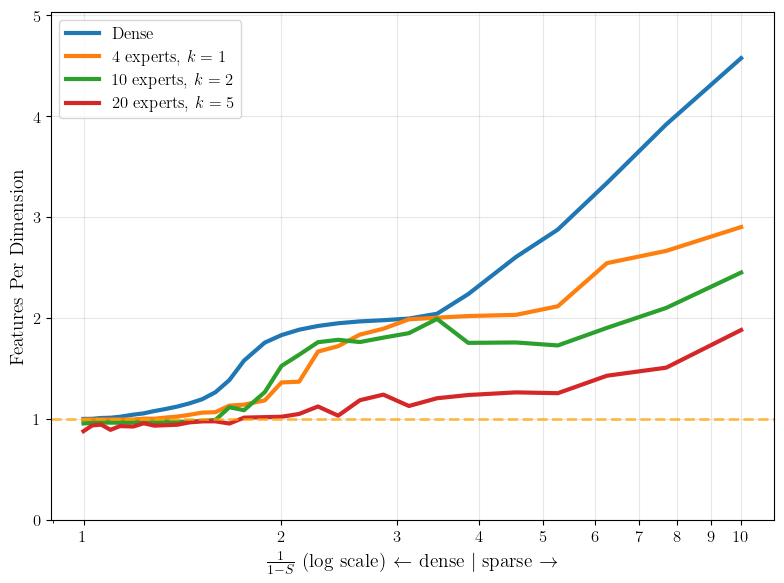

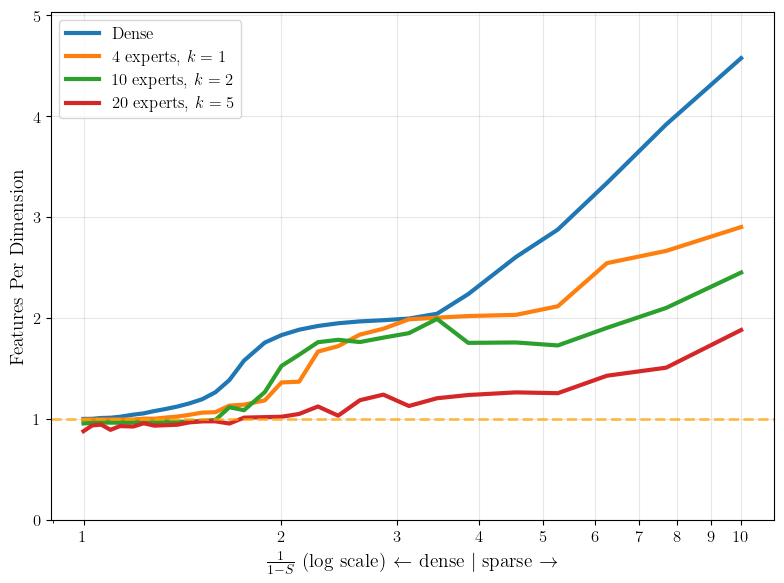

In [ ]:
plot_feats_per_dim_comparison_all(
    stacked_params_dense_30,
    configs_dense_30,
    stacked_params_moe_30,
    configs_moe_30,
    stacked_params_moe_10,
    configs_moe_10,
    stacked_params_moe_20,
    configs_moe_20,
    feature_probs_10,
    importances_10,
    feature_probs_10,
    importances_10,
    feature_probs_10,
    importances_10
)

In [93]:
def render_features_bar(model, save_path=None):
    """Render bar plots showing feature norms colored by polysemanticity"""
    cfg = model.config
    # expert weights
    W_exp = model.W_experts.detach()
    W_norm = W_exp / (1e-5 + torch.linalg.norm(W_exp, 2, dim=2, keepdim=True))

    interference = torch.einsum('ifh,igh->ifg', W_norm, W_exp) # (n_experts, n_features, n_features)
    interference[:, torch.arange(cfg.n_features), torch.arange(cfg.n_features)] = 0 # set diagonal to 0

    polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()
    norms = torch.linalg.norm(W_exp, 2, dim=-1).cpu()

    x = torch.arange(cfg.n_features)
    
    # set up matplotlib for LaTeX
    plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
        'font.serif': ['Computer Modern'],
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'legend.fontsize': 12,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
    })
    
    fig, axes = plt.subplots(cfg.n_experts, 1, figsize=(6, 4 * cfg.n_experts))
    if cfg.n_experts == 1:
        axes = [axes]
    
    for expert_idx in range(cfg.n_experts):
        ax = axes[expert_idx]
        
        # Create bar plot with color mapping and narrower bars
        bars = ax.bar(x, norms[expert_idx], 
                     color=plt.cm.viridis(polysemanticity[expert_idx] / polysemanticity[expert_idx].max()),
                     width=0.6)
        
        # Add colorbar using ScalarMappable
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=polysemanticity[expert_idx].max()))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Superposition')
        
        # Add vertical line at n_hidden boundary
        ax.axvline(x=(cfg.n_hidden-0.5), color='red', linestyle='--', alpha=0.7, linewidth=1)
        
        ax.set_title(f'Feature Norms')
        ax.set_xlabel('Features $\\rightarrow$')
        ax.set_ylabel('Norm $||W_i||$')
        ax.grid(True, alpha=0.3)
        
        # Set x-axis ticks to go from 0 to 5 to 10 to 15
        ax.set_xticks([0, 5, 10, 15])
        
        # Set x-axis limits to reduce horizontal width
        ax.set_xlim(-0.5, cfg.n_features - 0.5)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}_bar.pdf", bbox_inches='tight')
        plt.savefig(f"{save_path}_bar.pgf", bbox_inches='tight')
    
    plt.show()
    return fig

def render_features_heatmap(model, save_path=None):
    """Render heatmaps showing weight-weight transpose matrices"""
    cfg = model.config
    W_exp = model.W_experts.detach()
    
    WWT = torch.einsum('eij,ekj->eik', W_exp, W_exp).cpu() # (n_experts, n_features, n_features)
    
    # set up matplotlib for LaTeX
    plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
        'font.serif': ['Computer Modern'],
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'legend.fontsize': 12,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
    })
    
    fig, axes = plt.subplots(cfg.n_experts, 1, figsize=(6, 4 * cfg.n_experts))
    if cfg.n_experts == 1:
        axes = [axes]
    
    for expert_idx in range(cfg.n_experts):
        ax = axes[expert_idx]
        
        # Create heatmap with square aspect ratio
        im = ax.imshow(WWT[expert_idx].numpy(), 
                      cmap='coolwarm', 
                      vmin=-1, vmax=1,
                      aspect='equal')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Weight Element Values')
        
        ax.set_title(f'$W^TW$')
        # ax.set_xlabel('Feature')
        # ax.set_ylabel('Feature')
        
        # Set y-axis ticks to go from 0 to 5 to 10 to 15
        ax.set_yticks([0, 5, 10, 15])
        ax.set_xticks([0, 5, 10, 15])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}_heatmap.pdf", bbox_inches='tight')
        plt.savefig(f"{save_path}_heatmap.pgf", bbox_inches='tight')
    
    plt.show()
    return fig

In [91]:
config_m = Config(
    n_features = 20,
    n_hidden = 6,
    n_experts = 1,
    n_active_experts = 1,
    load_balancing_loss = False,
)
model_m = MoEModel(
    config=config_m,
    device=DEVICE,
    importance = 0.7**torch.arange(config_m.n_features), # torch.ones(config.n_features),
    feature_probability = torch.tensor(0.1)
)
optimize(model_m, n_batch=1024, steps=10000, print_freq=1000)

Step 0: loss=0.125578, lr=0.001000
Step 1000: loss=0.030150, lr=0.001000
Step 2000: loss=0.025532, lr=0.001000
Step 3000: loss=0.027935, lr=0.001000
Step 4000: loss=0.031820, lr=0.001000
Step 5000: loss=0.028606, lr=0.001000
Step 6000: loss=0.028547, lr=0.001000
Step 7000: loss=0.027154, lr=0.001000
Step 8000: loss=0.029762, lr=0.001000
Step 9000: loss=0.024989, lr=0.001000
Step 9999: loss=0.028256, lr=0.001000


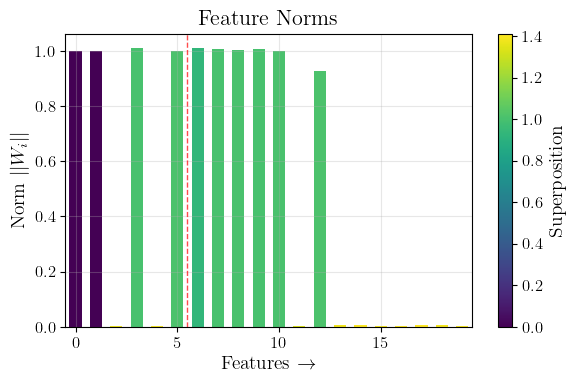

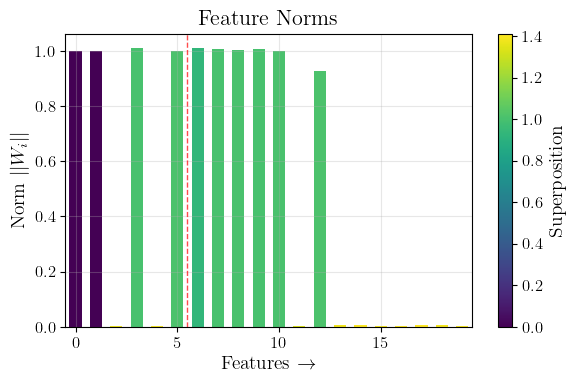

In [96]:
render_features_bar(model_m, save_path='d-bar')

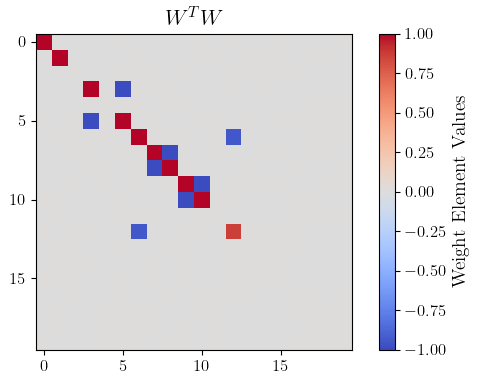

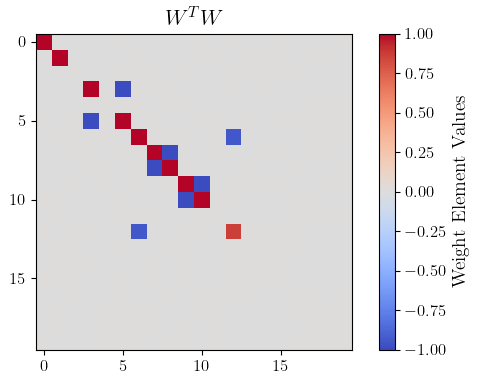

In [97]:
render_features_heatmap(model_m, save_path='d-heat')